In [28]:
####################################################################################################
# TF.SNOTEL.dataExploration
# Karl Lapo February/2016
####################################################################################################
# SWE Trends  
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
import kray
import scipy.io as sio

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_context('paper')
sns.set_style('whitegrid')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec

#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

# Directory for the SNOTEL data
dir_data = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/'
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'

## Read the SWE data from Mark

In [2]:
# Read netcdf versions of Mark's data
os.chdir(dir_data+'SNOTEL')
procSWE = xray.open_dataset('NRCS_all_daily_L3.nc')
SWEMetrics = xray.open_dataset('NRCS_snow_metrics.nc')

# Convert MATLAB datenum to numpy datetime 64
def matlabdn2datetime(matlabDatenum):
    npDatetime = [np.datetime64(datetime.fromordinal(int(dt))\
                                + timedelta(days=float(np.remainder(dt,1)))\
                                - timedelta(days = 366))\
                    for dt in matlabDatenum]        
    return(npDatetime)
snotelTime = procSWE.SERIAL_DATE
snotelTimePY = matlabdn2datetime(snotelTime)

# Convert the 'char_width_field' variables to a python string
def stringJoin(strIn,axis):
    strOut = "".join(strIn).rstrip()
    return(strOut)
stName = procSWE['STA_NAME'].groupby('nSTA').reduce(stringJoin,dim='char_field_width')
stNetwork = procSWE['STA_NETWORK'].groupby('nSTA').reduce(stringJoin,dim='char_field_width')
stState = procSWE['STA_STATE'].groupby('nSTA').reduce(stringJoin,dim='char_field_width')

# xarray Dataset
SNOTEL = xray.Dataset( {'SWE': (['nSTA','t'], procSWE['WTEQ_mm'])},
                        coords={'t': snotelTimePY})

# Additional coordinates
SNOTEL.coords['stName'] = stName
SNOTEL.coords['stNetwork'] = stNetwork
SNOTEL.coords['stState'] = stState
SNOTEL.coords['lat'] = procSWE['STA_LAT']
SNOTEL.coords['lon'] = procSWE['STA_LON']
SNOTEL.coords['elev'] = procSWE['STA_ELEV_m']
SNOTEL.coords['DOY'] = (('t'), procSWE['DOY'])

In [3]:
def water_year(time_index, last_month=9):
    year = time_index.to_index().year
    year[time_index.to_index().month > last_month] += 1 
    return xray.DataArray(year, dims=time_index.dims, coords=time_index.coords, name='water_year')

In [4]:
def max_SWE(swe, dim='t'):
    # Find the indicies of the max swe
    maxinds = swe.argmax(dim=dim)
    # find the index of the first day where swe < thresh
    return (swe[maxinds])

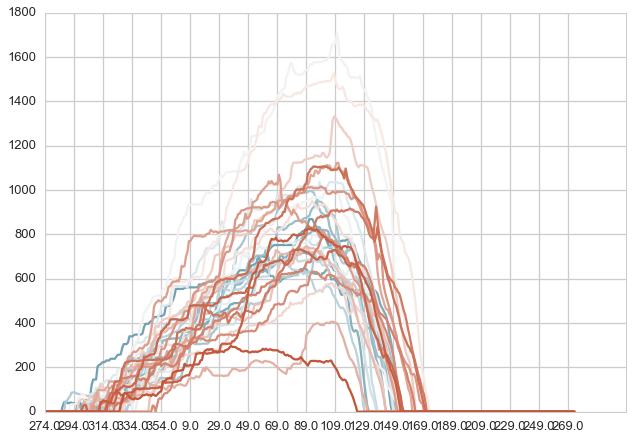

In [5]:
wy = SNOTEL.groupby(water_year(SNOTEL.t))
colscheme = sns.set_palette(sns.diverging_palette(220, 20, n=np.size(wy.groups.keys())))
for wYear,wYearSWE in wy:
    plt.plot(wYearSWE.SWE.swap_dims({'nSTA':'stName'}).sel(stName='Sasse Ridge'),\
             color=colscheme)
plt.xticks(np.arange(0,366,20),wYearSWE.DOY[0::20].values);

In [6]:
def noSWEChange(ds,dim='t',deltaTol=1,noSnowTol=5):
    # Defines the periods when SWE > 0 and SWE is unchanged by accumulation or melt
    indSnowPresent = ds.SWE > noSnowTol
    indSnowChange = np.absolute(S.SWE.diff(dim=dim)) < deltaTol & indSnowPresent
    return indSnowPresent, indSnowChange

def noSWEMelt(ds,dim='t',deltaTol=0,noSnowTol=0):
    # Defines the periods when SWE > 0 and SWE is unchanged by accumulation or melt
    ds['indSnowPresent'] = ds.SWE > noSnowTol
    deltaSWE = (ds.SWE.diff(dim='t') >= deltaTol).reindex_like(ds,method='nearest')
    ds['indSnowChange'] = deltaSWE & ds['indSnowPresent']
    return ds

def fracSnowDuration(ds,dim='t'):
    # Define the fraction of time with snow present during which snow did not change
    indSnowChange = ds['indSnowChange']
    indSnowPresent = ds['indSnowPresent']
    ds['fracSD'] = indSnowChange.sum(dim=dim).astype(float)/indSnowPresent.sum(dim=dim).astype(float)
    return ds

In [7]:
ds = SNOTEL#.resample(freq='H',how='mean',dim='t')
ds = noSWEMelt(ds)
ds = fracSnowDuration(ds)
print(ds)
print(ds.swap_dims({'nSTA':'stName'}).sel(stName='Grizzly Peak'))


<xray.Dataset>
Dimensions:         (nSTA: 823, t: 13149)
Coordinates:
  * t               (t) datetime64[ns] 1979-10-01 1979-10-02 1979-10-03 ...
  * nSTA            (nSTA) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    stName          (nSTA) object 'Crescent Lake #1' 'Glacial Ridge' ...
    stNetwork       (nSTA) object 'SCAN' 'SCAN' 'SCAN' 'SCAN' 'SCAN' 'SCAN' ...
    stState         (nSTA) object 'MN' 'MN' 'NH' 'NH' 'NV' 'PA' 'VT' 'VT' ...
    lat             (nSTA) float64 45.42 47.72 43.93 43.78 41.9 40.67 43.05 ...
    lon             (nSTA) float64 -93.95 -96.27 -71.72 -72.03 -119.4 -76.67 ...
    elev            (nSTA) float64 298.7 342.9 451.1 426.7 1.786e+03 222.5 ...
    DOY             (t) float64 274.0 275.0 276.0 277.0 278.0 279.0 280.0 ...
Data variables:
    SWE             (nSTA, t) float64 nan nan nan nan nan nan nan nan nan ...
    indSnowPresent  (nSTA, t) bool False False False False False False False ...
    indSnowChange   (nSTA, t) bool False False Fa

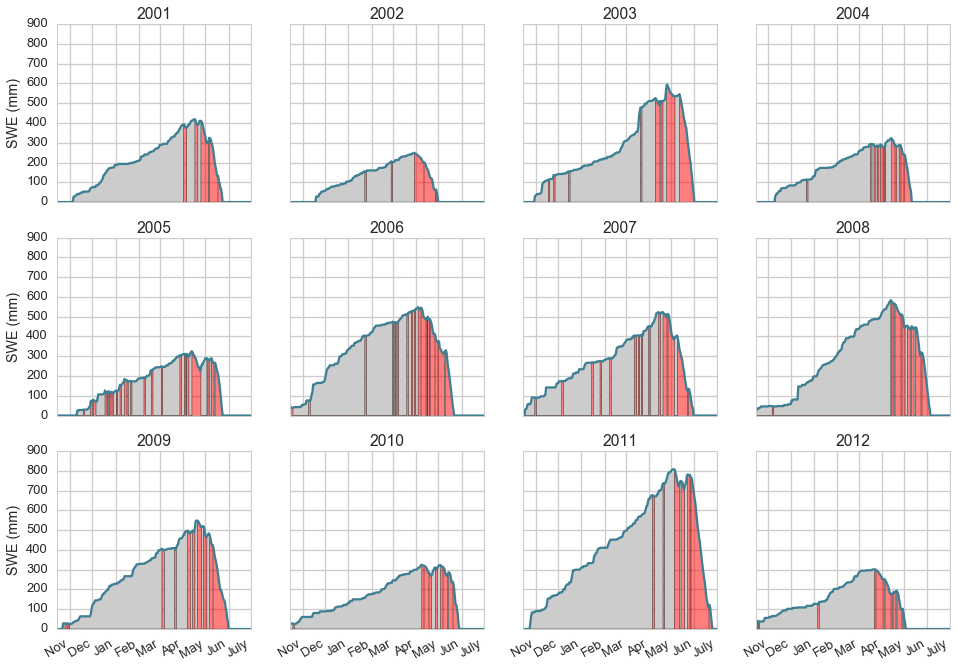

In [8]:
##### Plotting periods of no melt -- Multiple Water Years
import matplotlib.dates as mdates
monthsFmt = mdates.DateFormatter("%m")
monthLabels= ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','July']

# Grab a single station
S = ds.swap_dims({'nSTA':'stName'}).sel(stName='Grizzly Peak')
wy = S.groupby(water_year(S.t))

# Plot - mulitple water years
fig,axes = plt.subplots(3,4,figsize=(16,12),sharey=True)
axCount = 0
for wYear,wYearSWE in wy:
    if (wYear > 2000) & (wYear < 2013):
        ax = axes.flatten()[axCount]
        axCount = axCount + 1
        ax.plot(wYearSWE.t,wYearSWE.SWE)
        ax.set_xlim(datetime(wYear-1,10,15),datetime(wYear,7,1))
        ax.fill_between(wYearSWE.t.values,0,wYearSWE.SWE,\
               where=wYearSWE.SWE>0,facecolor='r',alpha=.5)
        ax.fill_between(wYearSWE.t.values,0,wYearSWE.SWE,\
                       where=wYearSWE.indSnowChange,facecolor=[.8,.8,.8])
        ax.set_title(str(wYear))
#         print(wYearSWE.fracSD)
        if (ax == axes[:,0]).any():
            ax.set_ylabel('SWE (mm)')
        if (ax == axes[-1,:]).any():
            ax.xaxis.set_major_formatter(monthsFmt)
            ax.set_xticklabels(monthLabels)
fig.autofmt_xdate()

<xray.DataArray 'fracSD' ()>
array(0.8317435082140965)
Coordinates:
    lon        float64 -105.9
    stName     object 'Grizzly Peak'
    stNetwork  object 'SNTL'
    lat        float64 39.65
    elev       float64 3.383e+03
    nSTA       int64 136
    stState    object 'CO'


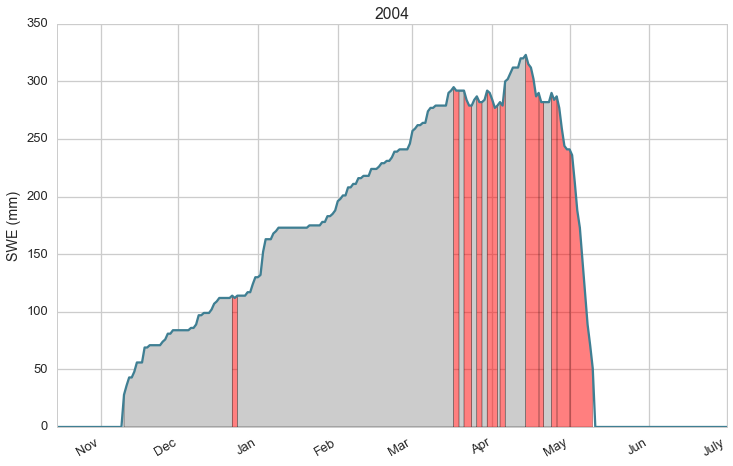

In [9]:
##### Plotting periods of no melt -- Single Water Year
import matplotlib.dates as mdates
monthsFmt = mdates.DateFormatter("%m")
monthLabels= ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','July']

# Grab a single station
S = ds.swap_dims({'nSTA':'stName'}).sel(stName='Grizzly Peak')
wy = S.groupby(water_year(S.t))

# Plot - mulitple water years
fig,ax = plt.subplots(1,1,figsize=(12,8))
for wYear,wYearSWE in wy:
    if wYear == 2004:
        ax.plot(wYearSWE.t,wYearSWE.SWE)
        ax.set_xlim(datetime(wYear-1,10,15),datetime(wYear,7,1))
        ax.fill_between(wYearSWE.t.values,0,wYearSWE.SWE,\
               where=wYearSWE.SWE>0,facecolor='r',alpha=.5)
        ax.fill_between(wYearSWE.t.values,0,wYearSWE.SWE,\
                       where=wYearSWE.indSnowChange,facecolor=[.8,.8,.8])
        ax.set_title(str(wYear))
        ax.set_ylabel('SWE (mm)')
        ax.xaxis.set_major_formatter(monthsFmt)
        ax.set_xticklabels(monthLabels)        
        print(wYearSWE.fracSD)

fig.autofmt_xdate()

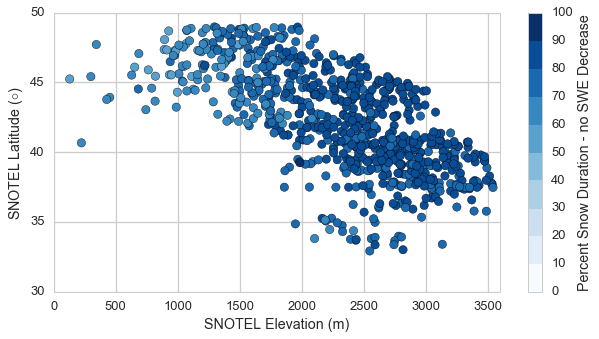

In [10]:
cmap = kgraph.cmap_discretize(cm.Blues,10)

## Figure of % time with no SWE change (either accumulation or ablation)
# fig,ax = plt.subplots(1,1,figsize=(10,5))
# SnoChange = noSWEChange(SNOTEL)
# cax = ax.scatter(SNOTEL['elev'],SNOTEL['lat'],s=70,c=SnoChange.mean('t')*100,vmin=0,vmax=35,cmap=cmap)
# ax.set_ylim(30,50)
# ax.set_xlim(0,3600)
# ax.set_ylabel('SNOTEL Latitude ($\circ$)')
# ax.set_xlabel('SNOTEL Elevation (m)')
# cbar = fig.colorbar(cax)
# cbar.ax.set_ylabel('Percent time - no SWE change')

## Figure of % time with no SWE melt (just negative SWE changes)
fig,ax = plt.subplots(1,1,figsize=(10,5))
cax = ax.scatter(ds['elev'],ds['lat'],s=70,c=ds['fracSD']*100,vmin=0,vmax=100,cmap=cmap)
ax.set_ylim(30,50)
ax.set_xlim(0,3600)
ax.set_ylabel('SNOTEL Latitude ($\circ$)')
ax.set_xlabel('SNOTEL Elevation (m)')
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel('Percent Snow Duration - no SWE Decrease')

## Figure of % time with no SWE melt (just negative SWE changes)
# fig,ax = plt.subplots(1,1,figsize=(10,5))
# SnoMelt = noSWEMelt(SNOTEL)
# cax = ax.scatter(SNOTEL['elev'],SNOTEL['lat'],s=70,\
#                  c=SnoMelt.groupby(water_year(SnoMelt.t)).mean('t').max(dim='water_year')*100,\
#                  vmin=0,vmax=70,cmap=cmap)
# ax.set_ylim(30,50)
# ax.set_xlim(0,3600)
# ax.set_ylabel('SNOTEL Latitude ($\circ$)')
# ax.set_xlabel('SNOTEL Elevation (m)')
# cbar = fig.colorbar(cax)
# cbar.ax.set_ylabel('Percent time - no SWE Decrease (max by water year)')

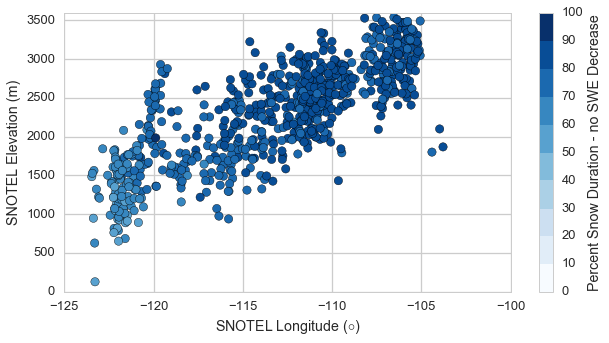

In [11]:
## Figure of % time with no SWE melt (just negative SWE changes)
cmap = kgraph.cmap_discretize(cm.Blues,10)
fig,ax = plt.subplots(1,1,figsize=(10,5))
cax = ax.scatter(ds['lon'],ds['elev'],s=70,c=ds['fracSD']*100,vmin=0,vmax=100,cmap=cmap)
ax.set_xlim(-125,-100)
ax.set_ylim(0,3600)
ax.set_xlabel('SNOTEL Longitude ($\circ$)')
ax.set_ylabel('SNOTEL Elevation (m)')
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel('Percent Snow Duration - no SWE Decrease')


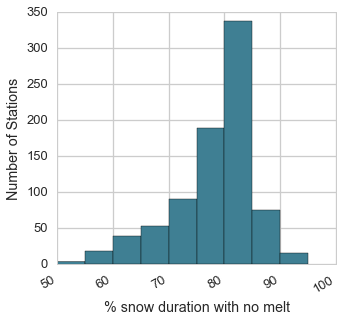

In [14]:
## Histogram of station melt percent
fig,ax = plt.subplots(1,1,figsize=(5,5))
n, bins, patches = plt.hist(ds.fracSD*100.,np.arange(0.5,1.,.05)*100)

# Format
ax.set_xlabel('% snow duration with no melt')
ax.set_ylabel('Number of Stations')
fig.autofmt_xdate()


0.831743508214


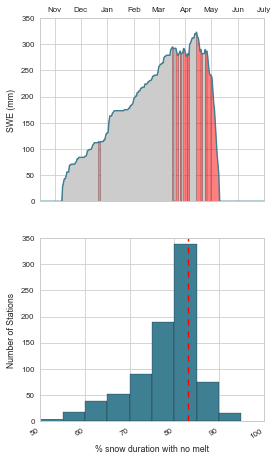

In [51]:
fig,axes = plt.subplots(2,1,figsize=(4,8))

## Histogram of station melt percent
ax = axes[1]
n, bins, patches = ax.hist(ds.fracSD*100.,np.arange(0.5,1.,.05)*100)
ax.plot(np.array((wYearSWE.fracSD.values*100,wYearSWE.fracSD.values*100)),np.array((0,350)),'r--')

# Format
ax.set_xlabel('% snow duration with no melt')
ax.set_ylabel('Number of Stations')
fig.autofmt_xdate()

## Plotting periods of no melt -- Single Water Year
ax = axes[0]
monthsFmt = mdates.DateFormatter("%m")
monthLabels= ['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','July']

# Grab a single station
S = ds.swap_dims({'nSTA':'stName'}).sel(stName='Grizzly Peak');
wy = S.groupby(water_year(S.t));

# Plot - mulitple water years
for wYear,wYearSWE in wy:
    if wYear == 2004:
        ax.plot(wYearSWE.t,wYearSWE.SWE)
        ax.set_xlim(datetime(wYear-1,10,15),datetime(wYear,7,1))
        ax.fill_between(wYearSWE.t.values,0,wYearSWE.SWE,\
               where=wYearSWE.SWE>0,facecolor='r',alpha=.5)
        ax.fill_between(wYearSWE.t.values,0,wYearSWE.SWE,\
                       where=wYearSWE.indSnowChange,facecolor=[.8,.8,.8])
        ax.set_ylabel('SWE (mm)')
        ax.xaxis.set_major_formatter(monthsFmt)
        ax.set_xticklabels(monthLabels)        
        ax.xaxis.tick_top()

        print(wYearSWE.fracSD.values)

os.chdir(dirPrint)
fig.savefig('WSC2016.Figure1.MeltFracSD.pdf')

In [53]:
SNOTEL

<xray.Dataset>
Dimensions:         (nSTA: 823, t: 13149)
Coordinates:
  * t               (t) datetime64[ns] 1979-10-01 1979-10-02 1979-10-03 ...
  * nSTA            (nSTA) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    stName          (nSTA) object 'Crescent Lake #1' 'Glacial Ridge' ...
    stNetwork       (nSTA) object 'SCAN' 'SCAN' 'SCAN' 'SCAN' 'SCAN' 'SCAN' ...
    stState         (nSTA) object 'MN' 'MN' 'NH' 'NH' 'NV' 'PA' 'VT' 'VT' ...
    lat             (nSTA) float64 45.42 47.72 43.93 43.78 41.9 40.67 43.05 ...
    lon             (nSTA) float64 -93.95 -96.27 -71.72 -72.03 -119.4 -76.67 ...
    elev            (nSTA) float64 298.7 342.9 451.1 426.7 1.786e+03 222.5 ...
    DOY             (t) float64 274.0 275.0 276.0 277.0 278.0 279.0 280.0 ...
Data variables:
    SWE             (nSTA, t) float64 nan nan nan nan nan nan nan nan nan ...
    indSnowPresent  (nSTA, t) bool False False False False False False False ...
    indSnowChange   (nSTA, t) bool False False Fa

### 